## Create and run a simple quantum program (using a simulator)


### Step 1. Map the problem to a quantum-native format


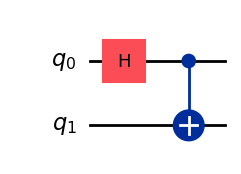

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

In [2]:
# Set up six different observables.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

### Step 2. Optimize the circuits and operators


In [3]:
 
# Use the following code instead if you want to run on a simulator:
 
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
backend = FakeAlmadenV2()
estimator = Estimator(backend)
 
# Convert to an ISA circuit and layout-mapped observables.
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
 
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
 
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
 
pub_result = job.result()[0]

In [4]:
backend.num_qubits

20

### Step 3. Execute using the quantum primitives

### Step 4. Analyze the results


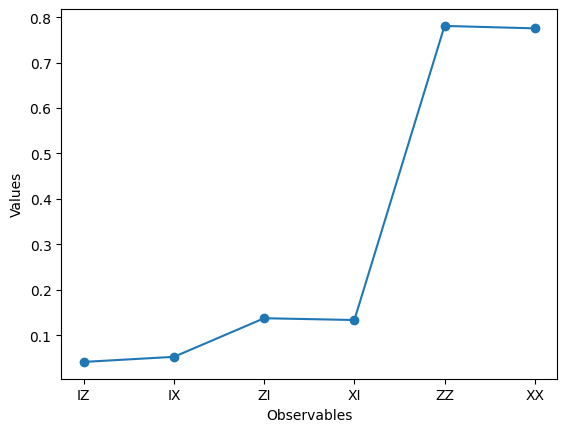

In [5]:
# Plot the result
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

## Scale to large numbers of qubits

### Step 1. Map the problem


In [6]:
from qiskit import QuantumCircuit
 
 
def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.
 
    Args:
        n (int): Number of qubits in the n-qubit GHZ state
 
    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
    """
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n - 1):
            qc.cx(i, i + 1)
    else:
        raise Exception("n is not a valid input")
    return qc
 
 
# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
n = 20
qc = get_qc_for_n_qubit_GHZ_state(n)

In [7]:
from qiskit.quantum_info import SparsePauliOp
 
# ZZII...II, ZIZI...II, ... , ZIII...IZ
operator_strings = [
    "Z" + "I" * i + "Z" + "I" * (n - 2 - i) for i in range(n - 1)
]
print(operator_strings)
print(len(operator_strings))
 
operators = [SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIII', 'ZIIIIIIIIIIZIIIIIIII', 'ZIIIIIIIIIIIZIIIIIII', 'ZIIIIIIIIIIIIZIIIIII', 'ZIIIIIIIIIIIIIZIIIII', 'ZIIIIIIIIIIIIIIZIIII', 'ZIIIIIIIIIIIIIIIZIII', 'ZIIIIIIIIIIIIIIIIZII', 'ZIIIIIIIIIIIIIIIIIZI', 'ZIIIIIIIIIIIIIIIIIIZ']
19


### Step 2. Optimize the problem for execution on quantum hardware

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# Use the following code instead if you want to run on a simulator:
 
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
backend = FakeAlmadenV2()
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
 
isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]

### Step 3. Execute on hardware


In [9]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"
 
# Create an Estimator object
estimator = Estimator(backend, options=options)

In [10]:
# Submit the circuit to Estimator
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(job_id)

224b7ae8-daf0-4c8a-8ef9-81bfe442453b


c:\Program Files\Python312\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:186: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")
c:\Program Files\Python312\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:268: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


### Step 4. Post-process results

In [ ]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
 
# data
data = list(range(1, len(operators) + 1))  # Distance between the Z operators
result = job.result()[0]
values = result.data.evs  # Expectation value at each Z operator.
values = [
    v / values[0] for v in values
]  # Normalize the expectation values to evaluate how they decay with distance.
 
# plotting graph
plt.plot(data, values, marker="o", label="20-qubit GHZ state")
plt.xlabel("Distance between qubits $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()